In [20]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error


In [21]:
df = pd.read_csv("https://storage.googleapis.com/public-quant/course//content/insurance.csv") 

In [22]:
df

age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns]

## 1. Perform an EDA

In [23]:
pip install -U dataprep --quiet


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
from dataprep.eda import *
from dataprep.datasets import load_dataset
from dataprep.eda import plot, plot_correlation, plot_missing, plot_diff, create_report

### Summary Statistics

In [25]:
df.describe(include='all')

age   sex          bmi     children smoker     region  \
count   1338.000000  1338  1338.000000  1338.000000   1338       1338   
unique          NaN     2          NaN          NaN      2          4   
top             NaN  male          NaN          NaN     no  southeast   
freq            NaN   676          NaN          NaN   1064        364   
mean      39.207025   NaN    30.663397     1.094918    NaN        NaN   
std       14.049960   NaN     6.098187     1.205493    NaN        NaN   
min       18.000000   NaN    15.960000     0.000000    NaN        NaN   
25%       27.000000   NaN    26.296250     0.000000    NaN        NaN   
50%       39.000000   NaN    30.400000     1.000000    NaN        NaN   
75%       51.000000   NaN    34.693750     2.000000    NaN        NaN   
max       64.000000   NaN    53.130000     5.000000    NaN        NaN   

             charges  
count    1338.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean    13270.422265  
std     12110.011237  
min      1121.873900  
25%      4740.287150  
50%      9382.033000  
75%     16639.912515  
max     63770.428010

In [26]:
print(df['region'].value_counts())
print(df['sex'].value_counts())
print(df['smoker'].value_counts())

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64
male      676
female    662
Name: sex, dtype: int64
no     1064
yes     274
Name: smoker, dtype: int64


we can notice that for charges of the insurance, which is the target feature we want to predict, has a higher mean than median, which means it is right skewed, meaning some small portion of the clients might have much higher insurance charges relatively to others--which increases the mean but not the median. Since all other numerical features(like age, bmi, children) has relatively close mean and median, and categorical values such as sex and region are also relatively evenly distributed, it is worth assume that smoke or not might contribute to the difference of charges.

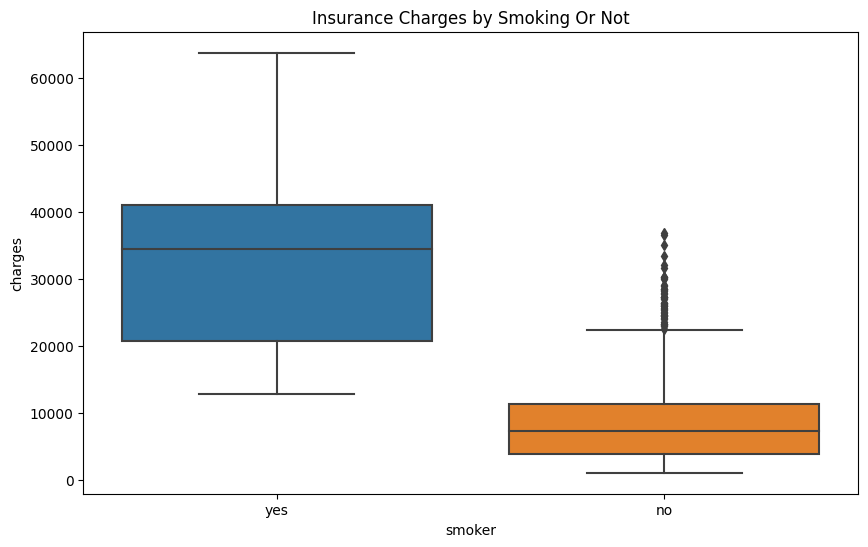

In [27]:

# Using seaborn to create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Insurance Charges by Smoking Or Not')
plt.show()


From the chart, we can see that the median of smoking people's charge is significantly higher, which means we might need to consider smoker as a weighted feature. However, we also see many outliers that has relatively high charges for no smokers, meaning that other features also has influence, for example, age is an important feature.

In [28]:
print(df[df['smoker'] == 'no'][df['charges'] >= 20000].age.mean())
print(df[df['smoker'] == 'no'][df['charges'] < 20000].age.mean())


45.131147540983605
39.03589232303091


/var/folders/6t/lkx7d7g12wd7bxxjd31tqdh40000gn/T/ipykernel_54451/1562550668.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[df['smoker'] == 'no'][df['charges'] >= 20000].age.mean())
/var/folders/6t/lkx7d7g12wd7bxxjd31tqdh40000gn/T/ipykernel_54451/1562550668.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[df['smoker'] == 'no'][df['charges'] < 20000].age.mean())


##### Check missing values

  0%|          | 0/121 [00:00<?, ?it/s]


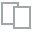
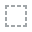
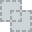
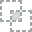
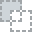
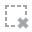
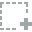
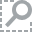
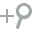
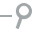
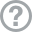
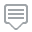
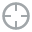
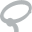
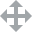
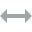
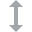
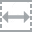
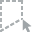
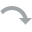
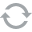
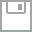
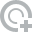
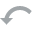
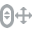
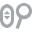
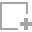
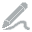
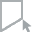
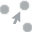
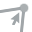
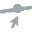

In [29]:
plot_missing(df)

/var/folders/6t/lkx7d7g12wd7bxxjd31tqdh40000gn/T/ipykernel_54451/1099242415.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


<Axes: title={'center': 'Correlation Matrix'}>

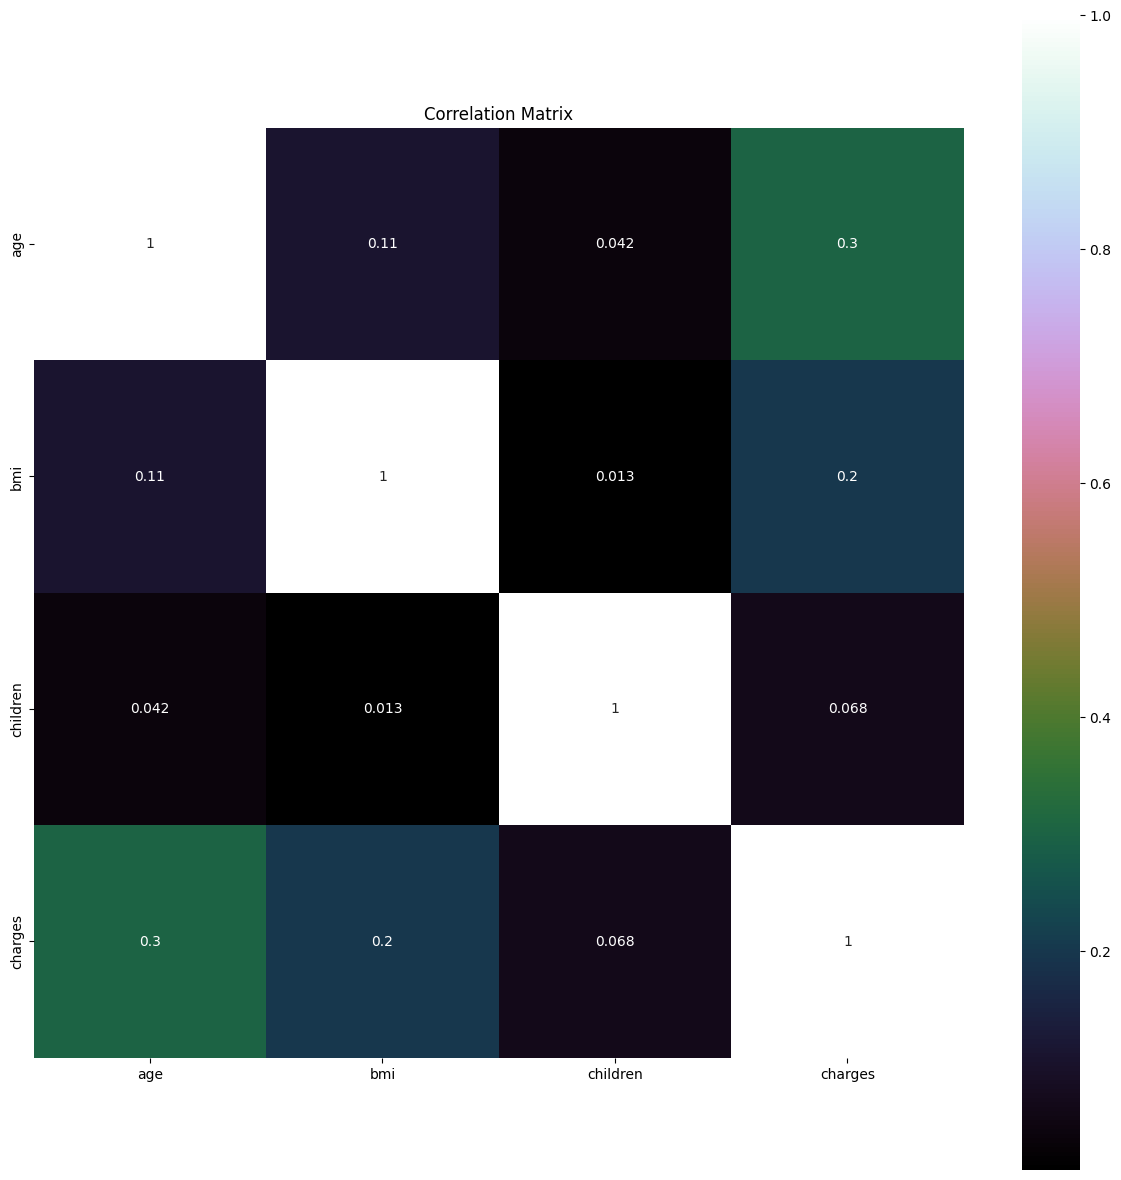

In [30]:
correlation = df.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


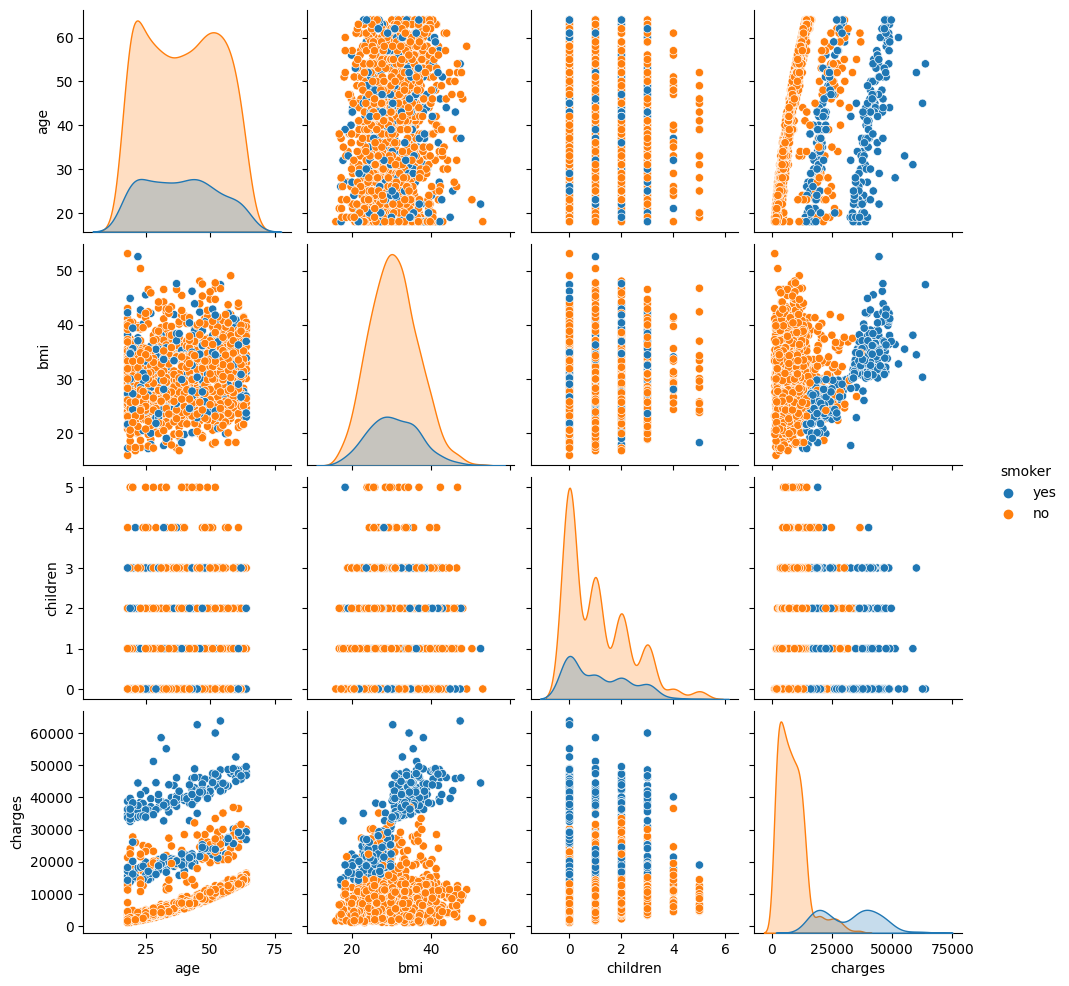

In [31]:
sns.pairplot(df, hue ='smoker')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


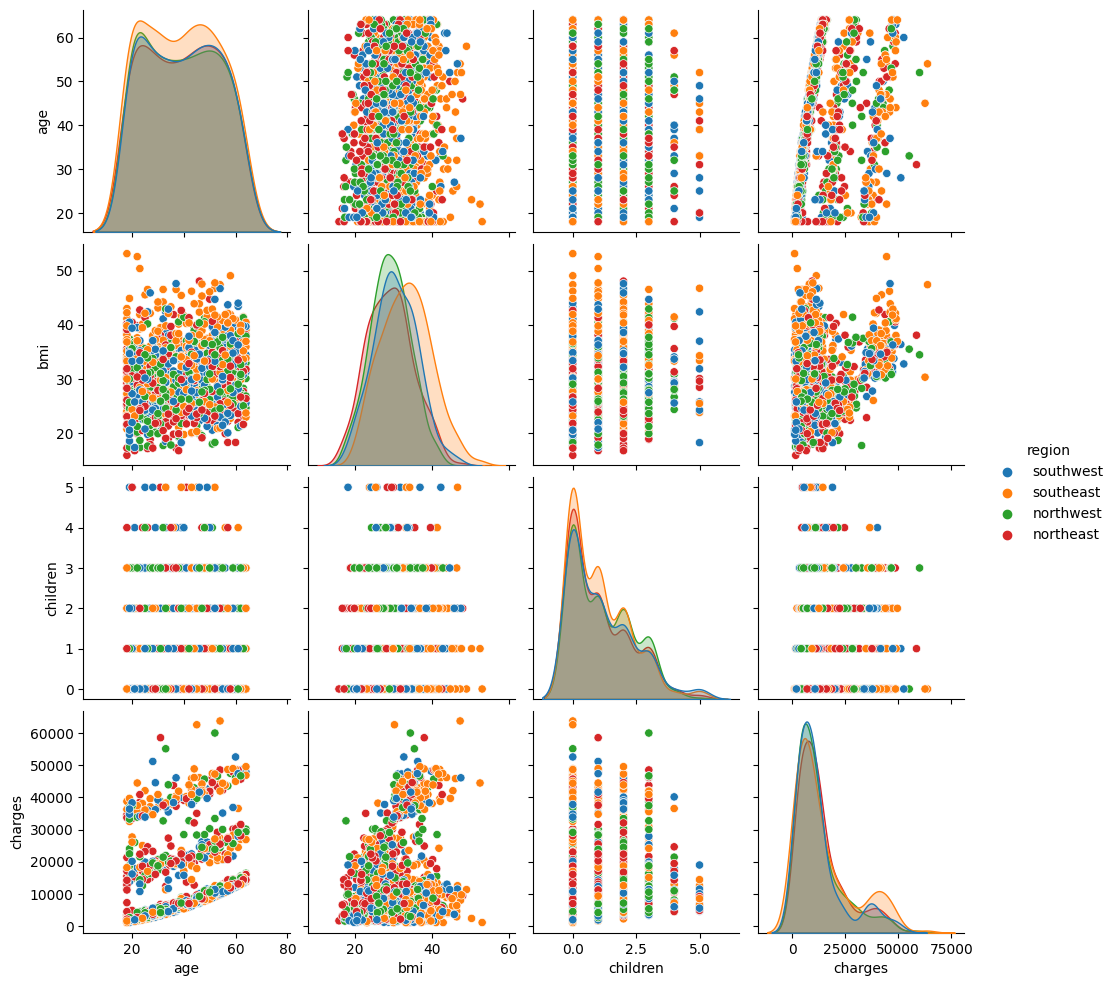

In [32]:
sns.pairplot(df, hue ='region')
plt.show()


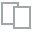
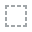
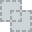
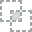
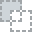
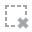
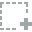
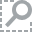
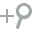
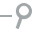
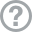
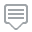
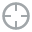
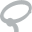
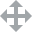
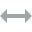
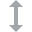
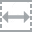
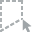
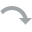
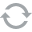
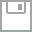
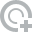
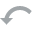
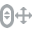
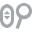
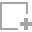
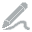
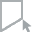
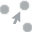
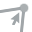
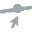

In [34]:
plot_correlation(df)

it appears that the age and the charges seems to have the greatest correlation, so plot it to see the relationship

We have already checked the missing values and this dataset has no NULL values

regions/sex/smoker are nominal data, which has no meaningful ordering

## 2. Preprocess the data


### Binary Encoded Dataset (one-hot encoding)

Since the feature region seems has no significance impact on the charges and is not an ordinal feature, we would like to use one-hot encoding for this feature. 
It is reasonable to use one-hot encoding here because our dataset has relatively low cardinality.

In [36]:
df = pd.get_dummies(df, columns = ['smoker','sex', 'region'])

In [37]:
df

age     bmi  children      charges  smoker_no  smoker_yes  sex_female  \
0      19  27.900         0  16884.92400          0           1           1   
1      18  33.770         1   1725.55230          1           0           0   
2      28  33.000         3   4449.46200          1           0           0   
3      33  22.705         0  21984.47061          1           0           0   
4      32  28.880         0   3866.85520          1           0           0   
...   ...     ...       ...          ...        ...         ...         ...   
1333   50  30.970         3  10600.54830          1           0           0   
1334   18  31.920         0   2205.98080          1           0           1   
1335   18  36.850         0   1629.83350          1           0           1   
1336   21  25.800         0   2007.94500          1           0           1   
1337   61  29.070         0  29141.36030          0           1           1   

      sex_male  region_northeast  region_northwest  region_southeast  \
0            0                 0                 0                 0   
1            1                 0                 0                 1   
2            1                 0                 0                 1   
3            1                 0                 1                 0   
4            1                 0                 1                 0   
...        ...               ...               ...               ...   
1333         1                 0                 1                 0   
1334         0                 1                 0                 0   
1335         0                 0                 0                 1   
1336         0                 0                 0                 0   
1337         0                 0                 1                 0   

      region_southwest  
0                    1  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
1333                 0  
1334                 0  
1335                 0  
1336                 1  
1337                 0  

[1338 rows x 12 columns]

### Fix Errors

In [38]:
df.drop_duplicates(keep="last")
df = df[~df["charges"].isnull()]
df#no duplicates

age     bmi  children      charges  smoker_no  smoker_yes  sex_female  \
0      19  27.900         0  16884.92400          0           1           1   
1      18  33.770         1   1725.55230          1           0           0   
2      28  33.000         3   4449.46200          1           0           0   
3      33  22.705         0  21984.47061          1           0           0   
4      32  28.880         0   3866.85520          1           0           0   
...   ...     ...       ...          ...        ...         ...         ...   
1333   50  30.970         3  10600.54830          1           0           0   
1334   18  31.920         0   2205.98080          1           0           1   
1335   18  36.850         0   1629.83350          1           0           1   
1336   21  25.800         0   2007.94500          1           0           1   
1337   61  29.070         0  29141.36030          0           1           1   

      sex_male  region_northeast  region_northwest  region_southeast  \
0            0                 0                 0                 0   
1            1                 0                 0                 1   
2            1                 0                 0                 1   
3            1                 0                 1                 0   
4            1                 0                 1                 0   
...        ...               ...               ...               ...   
1333         1                 0                 1                 0   
1334         0                 1                 0                 0   
1335         0                 0                 0                 1   
1336         0                 0                 0                 0   
1337         0                 0                 1                 0   

      region_southwest  
0                    1  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
1333                 0  
1334                 0  
1335                 0  
1336                 1  
1337                 0  

[1338 rows x 12 columns]

### Outlier Detection

In [39]:
def outlier_detect(data,col,threshold=3,method="IQR"):
  
    if method == "IQR":
      IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
      Lower_fence = data[col].quantile(0.25) - (IQR * threshold)
      Upper_fence = data[col].quantile(0.75) + (IQR * threshold)
    if method == "STD":
      Upper_fence = data[col].mean() + threshold * data[col].std()
      Lower_fence = data[col].mean() - threshold * data[col].std()   
    if method =="MAD":
      median = data[col].median()
      median_absolute_deviation = np.median([np.abs(y - median) for y in data[col]])
      modified_z_scores = pd.Series([0.6745 * (y - median) / median_absolute_deviation for y in data[col]])
      outlier_index = np.abs(modified_z_scores) > threshold
      print('Num of outlier detected:',outlier_index.value_counts()[1])
      print('Proportion of outlier detected',outlier_index.value_counts()[1]/len(outlier_index))
      return outlier_index, (median_absolute_deviation, median_absolute_deviation)

    para = (Upper_fence, Lower_fence)
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    print('Num of outlier detected:',outlier_index.value_counts()[1])
    print('Proportion of outlier detected',outlier_index.value_counts()[1]/len(outlier_index))
    
    return outlier_index, para
    

index,para = outlier_detect(df,"charges",threshold=1.5, method="IQR")
print('Upper bound:',para[0],'\nLower bound:',para[1])

Num of outlier detected: 139
Proportion of outlier detected 0.1038863976083707
Upper bound: 34489.350562499996 
Lower bound: -13109.1508975


In [40]:
df[(df['charges'] >para[0]) | (df['charges'] < para[1])].smoker_yes.sum() 

136

amoung 139 outliers, we have 136 who smoke. Since this shows that the feature smoke or not is very important, I think we should do nothing to the original data. If we drop or change the value to the charges value, the model might be influenced and failed to identify the important influence of smoking. 

### Train and Test Split and evaluation metrics

Since the data set has relatively low cardinality(i.e does not have a large amount of features/columns), I decided not to do feature selection and will use all features in the prediction model.

In [41]:
Y = df["charges"]
X = df.loc[:, df.columns != 'charges']
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)
X_train

age     bmi  children  smoker_no  smoker_yes  sex_female  sex_male  \
1317   18  53.130         0          1           0           0         1   
794    39  31.920         2          1           0           1         0   
680    21  17.400         1          1           0           1         0   
795    27  28.500         0          0           1           0         1   
887    36  30.020         0          1           0           1         0   
...   ...     ...       ...        ...         ...         ...       ...   
211    40  30.875         4          1           0           0         1   
502    51  23.210         1          0           1           0         1   
537    46  30.200         2          1           0           1         0   
1220   30  21.945         1          1           0           1         0   
175    63  37.700         0          0           1           1         0   

      region_northeast  region_northwest  region_southeast  region_southwest  
1317                 0                 0                 1                 0  
794                  0                 1                 0                 0  
680                  0                 0                 0                 1  
795                  0                 1                 0                 0  
887                  0                 1                 0                 0  
...                ...               ...               ...               ...  
211                  0                 1                 0                 0  
502                  0                 0                 1                 0  
537                  0                 0                 0                 1  
1220                 1                 0                 0                 0  
175                  0                 0                 0                 1  

[1070 rows x 11 columns]

### Standardize

Since the data contain numeric features with significantly different numeric features, we do standardization. We only standardize the train data set now(instead of standardize it before doing the train/test split) since we dont want to leak information from the training dataset into the test set which is not allowed. 

In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_validation)
X_train_scaled


array([[-1.47643983e+00,  3.67390113e+00, -9.06436014e-01, ...,
        -5.66557724e-01,  1.60953535e+00, -5.57919806e-01],
       [ 1.24949253e-03,  2.13575580e-01,  7.47249467e-01, ...,
         1.76504522e+00, -6.21297322e-01, -5.57919806e-01],
       [-1.26534135e+00, -2.15530358e+00, -7.95932732e-02, ...,
        -5.66557724e-01, -6.21297322e-01,  1.79237229e+00],
       ...,
       [ 4.93812599e-01, -6.70354501e-02,  7.47249467e-01, ...,
        -5.66557724e-01, -6.21297322e-01,  1.79237229e+00],
       [-6.32045930e-01, -1.41380525e+00, -7.95932732e-02, ...,
        -5.66557724e-01, -6.21297322e-01, -5.57919806e-01],
       [ 1.69003729e+00,  1.15655916e+00, -9.06436014e-01, ...,
        -5.66557724e-01, -6.21297322e-01,  1.79237229e+00]])

## 3. Build the models


In [43]:
models = []
models.append(('Linner Regression', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('Elastic Net', ElasticNet()))
models.append(('KNNeighbors', KNeighborsRegressor()))
models.append(('Descision Tree', DecisionTreeRegressor()))
models.append(('Gradient Boosting', GradientBoostingRegressor()))
models.append(('Random Forest', RandomForestRegressor()))

### k-folds cross validation

In [44]:
num_folds = 10
scoring = 'r2'
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=num_folds)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train_scaled, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Linner Regression: -0.737858 (0.041109)
LASSO: -0.737415 (0.040273)
Elastic Net: -0.699515 (0.032838)
KNNeighbors: -0.773196 (0.033931)
Descision Tree: -0.713606 (0.073069)
Gradient Boosting: -0.853382 (0.039616)
Random Forest: -0.835792 (0.043161)


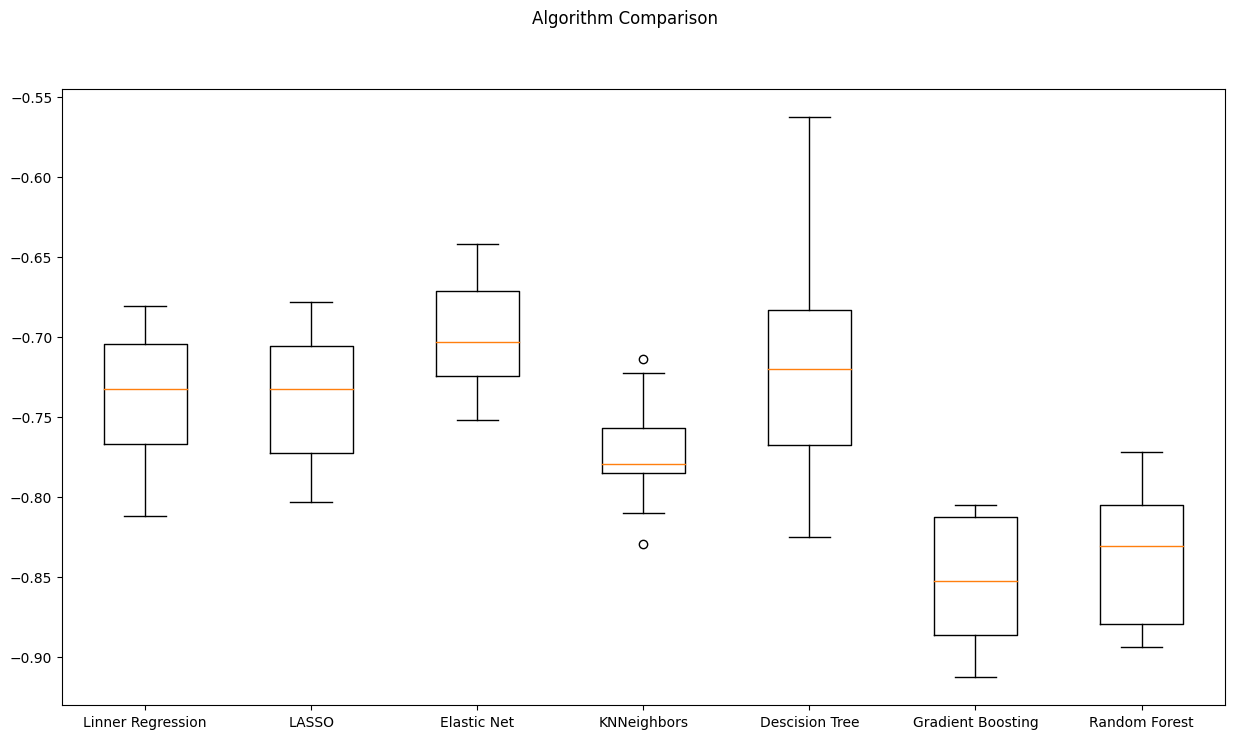

In [45]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

Despite Random Forest performance is close, GBR(Gradient Bossting) looks like is the best performing model and it is genereally more resistant to overfitting compared to other models, so we will choose this model.

The Linear models seems not a good fit for this data set, and the descision tree model shows a relatively low stability than others due to its wider range of performance score. 

### Model Tuning and Grid research

Given that the Gradient Boosting is the best model,we perform grid research on it

In [46]:

param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
}
model = GradientBoostingRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train_scaled, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.855437 using {'learning_rate': 0.05, 'n_estimators': 100}


In [47]:
model = GradientBoostingRegressor(learning_rate=grid_result.best_params_["learning_rate"],
    n_estimators=grid_result.best_params_["n_estimators"])
model.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.05)

In [48]:
from sklearn.metrics import r2_score
predictions_train = model.predict(X_train)
print(r2_score(Y_train, predictions_train))

0.8877415964497627


In [49]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#rescaledValidationX = scaler.transform(X_validation)
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_validation)
print("train:", mean_squared_error(Y_train, train_predictions))
print("train:", r2_score(Y_train, train_predictions))

print("test:", mean_squared_error(Y_validation, test_predictions))
print("test:", r2_score(Y_validation, test_predictions))

train: 16069334.67474384
train: 0.8877415964497627
test: 21593590.417791396
test: 0.8650263767226342


## 4. Explain the outputs

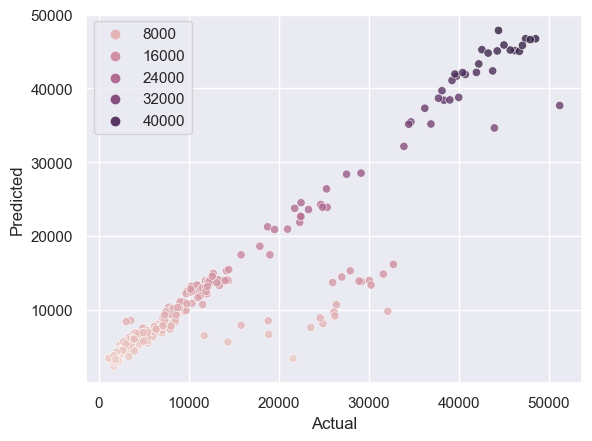

In [81]:
sns.set_theme(palette="muted")
sns.scatterplot(x=Y_validation, y=test_predictions,  alpha = 0.8, hue = test_predictions)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

From above graph, we can see that the trend is realatively linear and has a slope close to 1, indicating the model's prediction is close to the actual charges. However, there exists some points located down left, indicating we predict the charges much lower than the actual charges. I think these dots might be the outlier data points we detected earlier. 

In [51]:
model_fit = model.fit(X_train, Y_train)
Y_pred = pd.DataFrame(model_fit.predict(X_validation), index=Y_validation.index,
                      columns=['predict'])
Y_pred['test'] = Y_validation


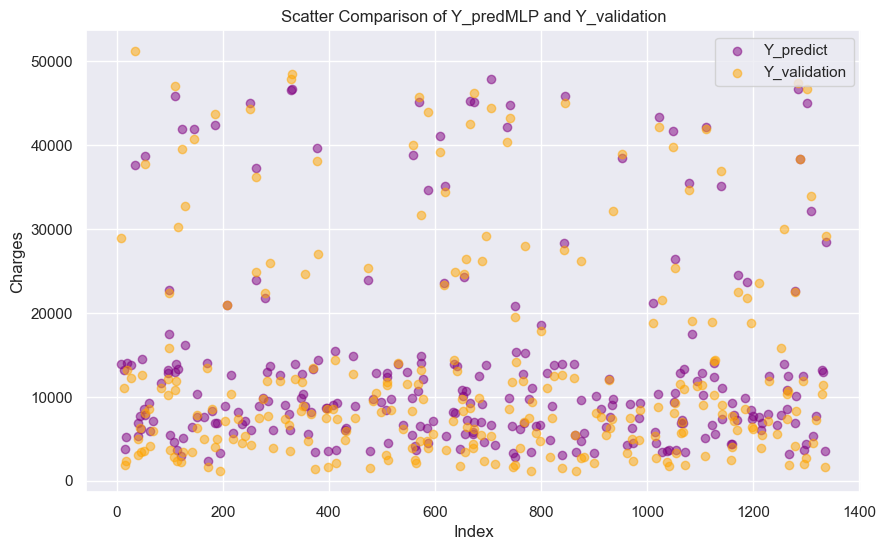

In [52]:
plt.figure(figsize=(10, 6))
plt.scatter(Y_pred.index, Y_pred['predict'], label='Y_predict', color='purple', alpha=0.5)
plt.scatter(Y_pred.index, Y_pred['test'], label='Y_validation', color='orange', alpha=0.5)

plt.title('Scatter Comparison of Y_predMLP and Y_validation')
plt.xlabel('Index')
plt.ylabel('Charges')
plt.legend()
plt.show()

From the above plots, we can see that the predicted charges shows a similar pattern with the actual values, meaning that our model is doing relativley well.

### Feature Importance

Feature Importance:  [1.13792387e-01 1.83519638e-01 8.61243454e-03 3.13440660e-01
 3.76062068e-01 3.56846747e-04 2.88315807e-04 9.39321154e-04
 1.98731958e-03 2.51583253e-04 7.49426098e-04]


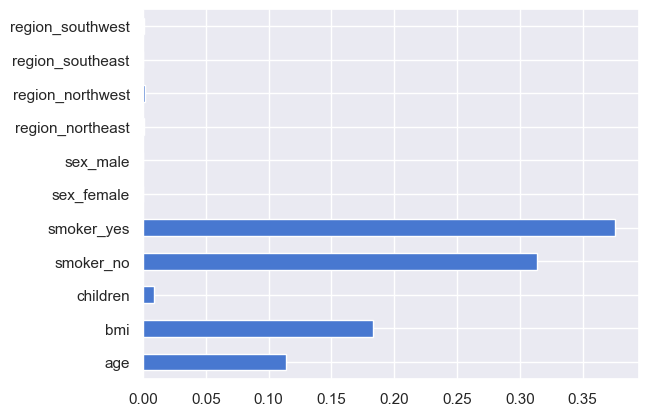

In [53]:
print("Feature Importance: ",model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.plot(kind='barh')
plt.show()

As shown in the above graph, the feature of smoking or not seems to be the most important faeture in this model, which matches our expectation in in the prevoius EDA part, it is clearly tha the distribution of the charges for smokers are significantly higher than non-smokers.

In [59]:
pip install shap --quiet



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


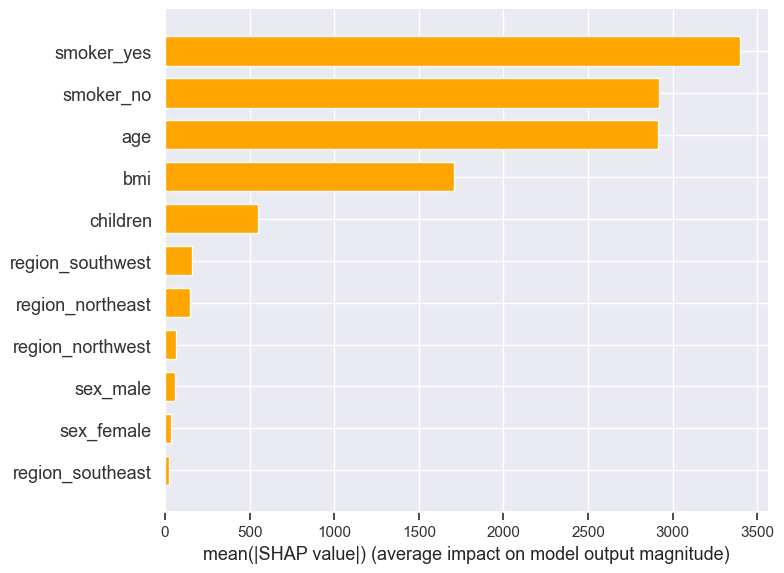

In [82]:
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_validation)
shap.summary_plot(shap_values, X_validation, plot_type='bar', color='orange')

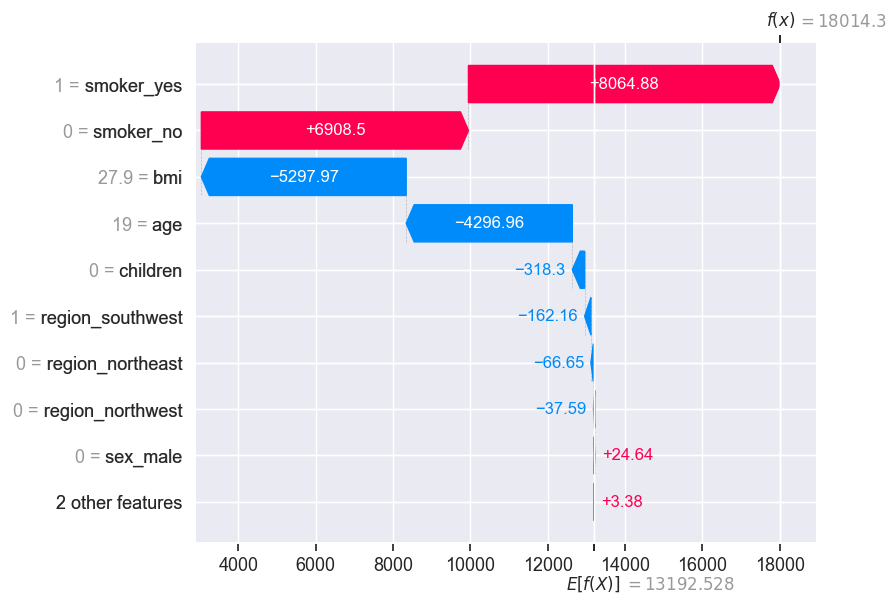

In [64]:
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])

As we can see from the above plot, smoker_yes significantly causes the increase of charges. despite smoker_no also shows an increase in y, I think that is because the insurance company has a base charge for every customer which age is the most importance. We can also observe that both yonger ages and less bmi drags the expected charges lower. Other features such as sex and region has a relatively minimal impact

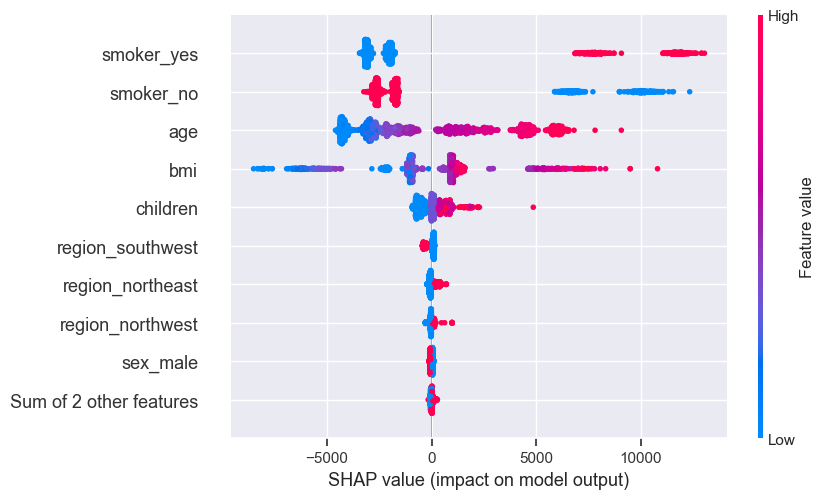

In [66]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

This plot is much more clearly that for both smokers and non-smokers, there exists two clusters, which I assume is dues to the characteristic of the insurance industry(base charge + charges for accident)

### Conclusion

In this model, we did a machine learning to predict the insurance charges. Features such as ages and smoking or not shows the biggest contribution to the model. However, each individual case is different for insurance charging, so the model will miss predict(tend to predict a lower value) for some of the outliers. We aboserved that the tree-based models such as gradient boosting and the random forest tend to perform better than linear models becasue this data set has non-linear relationships. In the model explanation part, the most important feature indeed matches our expectation of which feature will impact most in the EDA part. 

Some idea of how to improve the model in the future: I noticed that for both smokers and non-smokers, the charges data tend to have two layers. I am guessing that it might due to the characteristic of insurance industry, that the charges are composed by 2 parts, a basic annual fee and charges for accident. In order to improve performance, I think we can try to combine 2 models, one model to deal with each layer of the charges amount(basic annual fee and accident cost) and then combine them together in fiture studies. 